In [1]:
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, accuracy_score
import lightgbm as lgb
import datetime
import joblib
import seaborn as sns

In [2]:
df = pd.read_csv('ETHUSDT_Binance_futures_15_min.csv')

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [4]:
# df = df.resample('4H').agg({
#   'Unix': 'last',
#   'Symbol': 'last',
#   'Open': 'first',
#   'High': 'max',
#   'Low': 'min',
#   'Close': 'last',
#   'Volume': 'sum',
#   'Volume Base Asset': 'sum',
#   'tradecount': 'sum'
# })

In [5]:
# df.drop(['Unix', 'Symbol'], axis=1, inplace=True)

In [6]:
close_percentual_variation = df['Close'] / df['Close'].shift(1) - 1

descent_delta = close_percentual_variation.clip(upper=0) * -1 # limite máximo é 0 e multiplica por -1 pois a soma daria negativa
rise_delta = close_percentual_variation.clip(lower=0) # limite mínimo é 0

In [7]:
periods = 15

# calcula a média das últimas 14 linhas (ex.: 1-21, 2-22, ...)
descent_delta_average = descent_delta.rolling(window=periods).mean()
rise_delta_average = rise_delta.rolling(window=periods).mean()

In [8]:
rs = rise_delta_average / descent_delta_average

rsi = 100 - 100 / (1 + rs)

df['RSI'] = rsi
# df['RSI_High'] = list(map(lambda x: 1 if x > 70 else 0, rsi))
# df['RSI_Low'] = list(map(lambda x: 1 if x < 30 else 0, rsi))

## Bandas de Bollinger

In [9]:
# Calculate the Upper Bollinger Band (UB) and Lower Bollinger Band (LB)
df['UB'] = df['Close'].rolling(window=periods).mean() + 2 * df['Close'].rolling(window=periods).std()
df['LB'] = df['Close'].rolling(window=periods).mean() - 2 * df['Close'].rolling(window=periods).std()

## MACD

In [10]:
# Parâmetros para o MACD
short_window = 12  # Janela para a média móvel rápida (EMA)
long_window = 26   # Janela para a média móvel lenta (EMA)
signal_window = 9  # Janela para o sinal de EMA do MACD

# Calculando o MACD
df['MACD'] = df['Close'].ewm(span=short_window, adjust=False).mean() - df['Close'].ewm(span=long_window, adjust=False).mean()

# Calculando a linha de sinal do MACD
df['Signal_Line'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()

## ATR

In [11]:
# Calculando a faixa verdadeira (True Range - TR)
df['High_Low'] = df['High'] - df['Low']
df['High_Close'] = abs(df['High'] - df['Close'].shift())
df['Low_Close'] = abs(df['Low'] - df['Close'].shift())
df['TR'] = df[['High_Low', 'High_Close', 'Low_Close']].max(axis=1)

# Calculando o ATR (Average True Range)
period = 14  # Período comum para o ATR
df['ATR'] = df['TR'].rolling(window=period).mean()

# Limpando as colunas intermediárias, se desejado
df.drop(['High_Low', 'High_Close', 'Low_Close', 'TR'], axis=1, inplace=True)

## Rate-of-Change (ROC)

In [12]:
n_month = 24 * 30
n_week = 24 * 7

df['ROC_1M'] = ((df['Close'] - df['Close'].shift(n_month)) / df['Close'].shift(n_month)) * 100
df['ROC_1W'] = ((df['Close'] - df['Close'].shift(n_week)) / df['Close'].shift(n_week)) * 100

## Williams %R

In [13]:
# Calculando o Williams %R
df['Highest_High'] = df['High'].rolling(window=periods).max()
df['Lowest_Low'] = df['Low'].rolling(window=periods).min()
df['Williams_%R'] = ((df['Highest_High'] - df['Close']) / (df['Highest_High'] - df['Lowest_Low'])) * - 100

df.drop(['Highest_High', 'Lowest_Low'], axis=1, inplace=True)
# df.drop(['Highest_High', 'Lowest_Low', 'Williams_%R'], axis=1, inplace=True)

## Stochastic Oscillator

In [14]:
# Definindo o período para o cálculo das linhas %K e %D
n = 14  # Período comum para %K
d_n = 3  # Período comum para a média móvel %D

# Calculando a linha %K
df['Highest_High'] = df['High'].rolling(window=n).max()
df['Lowest_Low'] = df['Low'].rolling(window=n).min()
df['%K'] = ((df['Close'] - df['Lowest_Low']) / (df['Highest_High'] - df['Lowest_Low'])) * 100

# Calculando a linha %D como a média móvel simples de %K
df['%D'] = df['%K'].rolling(window=d_n).mean()

# Removendo as colunas intermediárias para limpar o DataFrame
df.drop(['Highest_High', 'Lowest_Low'], axis=1, inplace=True)

## Money Flow Index

In [15]:
# Calculando o preço típico
df['Typical_Price'] = (df['High'] + df['Low'] + df['Close']) / 3

# Calculando o fluxo de dinheiro
df['Money_Flow'] = df['Typical_Price'] * df['Volume Base Asset']

# Identificando fluxos positivos e negativos
df['Positive_Flow'] = df['Money_Flow'].where(df['Typical_Price'] > df['Typical_Price'].shift(), 0)
df['Negative_Flow'] = df['Money_Flow'].where(df['Typical_Price'] < df['Typical_Price'].shift(), 0)

# Definindo o período para o cálculo do MFI, geralmente 14 dias
period = 14

# Calculando a razão de fluxo de dinheiro
df['Money_Flow_Ratio'] = (df['Positive_Flow'].rolling(window=period).sum() / df['Negative_Flow'].rolling(window=period).sum())

# Calculando o MFI
df['MFI'] = 100 - (100 / (1 + df['Money_Flow_Ratio']))

df.drop(['Typical_Price', 'Money_Flow', 'Positive_Flow', 'Negative_Flow', 'Money_Flow_Ratio'], axis=1, inplace=True)

## Simple Moving Average Relative Differences

In [16]:
def calculate_SMA(df, window):
  return df.rolling(window=window).mean()

def relative_difference(series1, series2):
  return (series1 - series2) / series2

df['SMA5-20'] = relative_difference(calculate_SMA(df['Close'], 5), calculate_SMA(df['Close'], 20))
df['SMA8-15'] = relative_difference(calculate_SMA(df['Close'], 8), calculate_SMA(df['Close'], 15))
df['SMA20-50'] = relative_difference(calculate_SMA(df['Close'], 20), calculate_SMA(df['Close'], 50))

## Exponencial Moving Average Relative Differences

In [17]:
def calculate_EMA(df, span):
  return df.ewm(span=span, adjust=False).mean()

def relative_difference(series1, series2):
  return (series1 - series2) / series2

df['EMA5-20'] = relative_difference(calculate_EMA(df['Close'], 5), calculate_EMA(df['Close'], 20))
df['EMA8-15'] = relative_difference(calculate_EMA(df['Close'], 8), calculate_EMA(df['Close'], 15))
df['EMA20-50'] = relative_difference(calculate_EMA(df['Close'], 20), calculate_EMA(df['Close'], 50))

## Aroon Oscillator

In [18]:
def Williams(df, periods): # mesma coisa do williams lá em cima
  highest_high = df['High'].rolling(window=periods).max()
  lowest_low = df['Low'].rolling(window=periods).min()
  williams = ((highest_high - df['Close']) / (highest_high - lowest_low)) * -100

  return williams

df['AO14'] = Williams(df.copy(), 14)

## Average Directional Index

In [19]:
def adx(df, periods=14):
    df['High-Low'] = df['High'] - df['Low']
    df['High-PreviousClose'] = abs(df['High'] - df['Close'].shift(1))
    df['Low-PreviousClose'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['High-Low', 'High-PreviousClose', 'Low-PreviousClose']].max(axis=1)
    df['DMplus'] = np.where((df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']), 
                            df['High'] - df['High'].shift(1), 0)
    df['DMminus'] = np.where((df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)), 
                             df['Low'].shift(1) - df['Low'], 0)
    ATR = df['TR'].rolling(window=periods).mean()
    ADX = (abs(df['DMplus'] - df['DMminus']) / (df['DMplus'] + df['DMminus'])).rolling(window=periods).mean()
    return (ADX / ATR) * 100

df['ADX'] = adx(df.copy())

## Difference between Positive Directional Index (DI+) and Negative Directional Index (DI-)

In [20]:
def wd(df, periods=14):
    df['High-Low'] = df['High'] - df['Low']
    df['High-PreviousClose'] = abs(df['High'] - df['Close'].shift(1))
    df['Low-PreviousClose'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['High-Low', 'High-PreviousClose', 'Low-PreviousClose']].max(axis=1)
    df['DMplus'] = np.where((df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']), 
                            df['High'] - df['High'].shift(1), 0)
    df['DMminus'] = np.where((df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)), 
                             df['Low'].shift(1) - df['Low'], 0)
    TR = df['TR'].rolling(window=periods).sum()
    DMplus = df['DMplus'].rolling(window=periods).sum()
    DMminus = df['DMminus'].rolling(window=periods).sum()
    return abs((DMplus - DMminus) / TR)

df['WD'] = wd(df.copy())

## Percentage Price Oscillator

In [21]:
def ppo(df, short_window=12, long_window=26):
    short_ema = df['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = df['Close'].ewm(span=long_window, adjust=False).mean()
    return ((short_ema - long_ema) / long_ema) * 100

df['PPO'] = ppo(df.copy())

## True Strength Index

In [22]:
def tsi(df):
    M = df['Close'].diff(1)
    aM = abs(M)
    EMA1 = M.ewm(span=25).mean()
    aEMA1 = aM.ewm(span=25).mean()
    EMA2 = EMA1.ewm(span=13).mean()
    aEMA2 = aEMA1.ewm(span=13).mean()
    return 100 * EMA2 / aEMA2

df['TSI'] = tsi(df.copy())

## Chande Momentum Oscillator

In [23]:
def cmo(df, periods=14):
    diff = df['Close'] - df['Close'].shift(1)
    up = diff.where(diff > 0, 0)
    down = abs(diff.where(diff < 0, 0))
    sum_up = up.rolling(window=periods).sum()
    sum_down = down.rolling(window=periods).sum()
    return ((sum_up - sum_down) / (sum_up + sum_down)) * 100

df['CMO'] = cmo(df.copy())

## Percentage Volume Oscillator

In [24]:
def pvo(df, short_window=12, long_window=26):
    short_ema = df['Volume Base Asset'].ewm(span=short_window, adjust=False).mean()
    long_ema = df['Volume Base Asset'].ewm(span=long_window, adjust=False).mean()
    return ((short_ema - long_ema) / long_ema) * 100

df['PVO'] = pvo(df.copy())

## Accumulation Distribution Line

In [25]:
def adl(df):
    adl = ((2 * df['Close'] - df['High'] - df['Low']) / (df['High'] - df['Low'])) * df['Volume Base Asset']
    return adl.cumsum()

df['ADL'] = adl(df.copy())

## On Balance Volume

In [26]:
def obv(df):
    prev_obv = df['Volume Base Asset'].diff().fillna(0)
    prev_obv[prev_obv >= 0] = 1
    prev_obv[prev_obv < 0] = -1
    return (prev_obv * df['Volume Base Asset']).cumsum()

df['OBV'] = obv(df.copy())

## Force Index

In [27]:
def fi(df, periods):
    return df['Close'].diff(periods) * df['Volume Base Asset']

df['FI13'] = fi(df.copy(), 13)
df['FI50'] = fi(df.copy(), 50)

In [28]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

In [30]:
df['Expected Return'] = df['Close'].shift(-1) / df['Close'] - 1

In [33]:
def categorize_return(x):
    if x > 0.0005:
        return 1 # Buy
    elif x < -0.0005:
        return 0 # Sell
    else:
        return -1 # Stay Out
                    
split_point = int(len(df) * 0.5)

X = df.loc[:, df.columns != 'Expected Return']
Y = df['Expected Return'].apply(lambda x: categorize_return(x))

x_train = X[:split_point]
x_test = X[split_point:]

y_train = Y[:split_point]
y_test = Y[split_point:]

selector = SelectKBest(score_func=f_classif, k=9)

x_train2 = selector.fit_transform(x_train, y_train)
x_test2 = selector.transform(x_test)

model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=3,
    learning_rate=0.2,
    n_estimators=150,
    num_leaves=31,
    random_state=42,
)

model.fit(x_train2, y_train)

prediction = model.predict(x_test2)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 52579, number of used features: 9
[LightGBM] [Info] Start training from score -2.188891
[LightGBM] [Info] Start training from score -0.818941
[LightGBM] [Info] Start training from score -0.805061


In [35]:
df.columns[np.where(selector.get_support())[0]]

Index(['Volume', 'Volume Base Asset', 'ATR', 'Williams_%R', '%K', '%D', 'AO14',
       'ADX', 'CMO'],
      dtype='object')

In [37]:
x_test['Expected Return'] = x_test['Close'].shift(-1) / x_test['Close'] - 1

C:\Users\Vlademir\AppData\Local\Temp\ipykernel_10760\3050993691.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['Expected Return'] = x_test['Close'].shift(-1) / x_test['Close'] - 1


In [39]:
window_size = 24 
x_test['Volatility'] = x_test['Expected Return'].shift(1).rolling(window=window_size).std() * np.sqrt(4 * 24 * 7)

C:\Users\Vlademir\AppData\Local\Temp\ipykernel_10760\2173072227.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['Volatility'] = x_test['Expected Return'].shift(1).rolling(window=window_size).std() * np.sqrt(4 * 24 * 7)


In [40]:
x_test['Prediction'] = prediction

C:\Users\Vlademir\AppData\Local\Temp\ipykernel_10760\107671.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['Prediction'] = prediction


In [41]:
def get_fee(value):
  return value * 0.02 / 100

def calculate_drawdowns(history):
  history = np.array(history)
  peaks = np.maximum.accumulate(history)
  drawdowns = 100 * (history - peaks) / peaks
  
  return drawdowns

In [42]:
history = [500]

upper_band_1std = x_test["Volatility"][20] * x_test["Close"][20] + x_test["Close"][20]
lower_band_1std = x_test["Close"][20] - x_test["Volatility"][20] * x_test["Close"][20]
counter = 0
        # (old, new)
status = ('out', 'out') # '', 'long', 'long-std', 'short', 'short-std'

for index, row in x_test[20:-1].iterrows():
  if index.time() == datetime.time(6, 0):
    upper_band_1std = row["Volatility"] * row["Close"] + row["Close"]
    lower_band_1std = row["Close"] - row["Volatility"] * row["Close"]

  isFeeNeeded = False

  if row['Prediction'] == 1 or row['FI50'] >= 637245.104: # entra ou mantém posição
    if row['Close'] < lower_band_1std:
      counter += 1
      new_value = history[-1] * (1 + row['Expected Return'] * 30)

      if status[1] != 'long-std': # entra na posição
        if status[1] != 'out': # paga fee da antiga posição
          isFeeNeeded = True

        status = (status[1], 'long-std')
        
    else:
      new_value = history[-1] * (1 + row['Expected Return'] * 3)

      if status[1] != 'long': # entra na posição
        if status[1] != 'out': # paga fee da antiga posição
          isFeeNeeded = True

        status = (status[1], 'long')

  # elif row['Prediction'] == 0: # entra ou mantém posição
  #   if row['Close'] > upper_band_1std:
  #     new_value = history[-1] * (1 + row['Expected Return'] * - 1 * 1)

  #     if status[1] != 'short-std': # entra na posição
  #       if status[1] != 'out': # paga fee da antiga posição
  #         isFeeNeeded = True

  #       status = (status[1], 'short-std')
  #   else:
  #     new_value = history[-1] * (1 + row['Expected Return'] * - 1 * 1)

  #     if status[1] != 'short': # entra na posição
  #       if status[1] != 'out': # paga fee da antiga posição
  #         isFeeNeeded = True

  #       status = (status[1], 'short')

  elif row['Prediction'] == -1:
    if status[1] != 'out': # sai da posição
      isFeeNeeded = True

      status = (status[1], 'out')

  if not (status[0] == 'out' and status[1] == 'out'):
    fee = get_fee(new_value) if isFeeNeeded else 0

    history.append(new_value - fee)

print(history[-1] / history[0] - 1)
print(np.min(calculate_drawdowns(history)))

1422.9598017412218
-74.14301817410109


In [43]:
x_test['Close'][-1] / x_test['Close'][0] - 1

1.3960362318840582

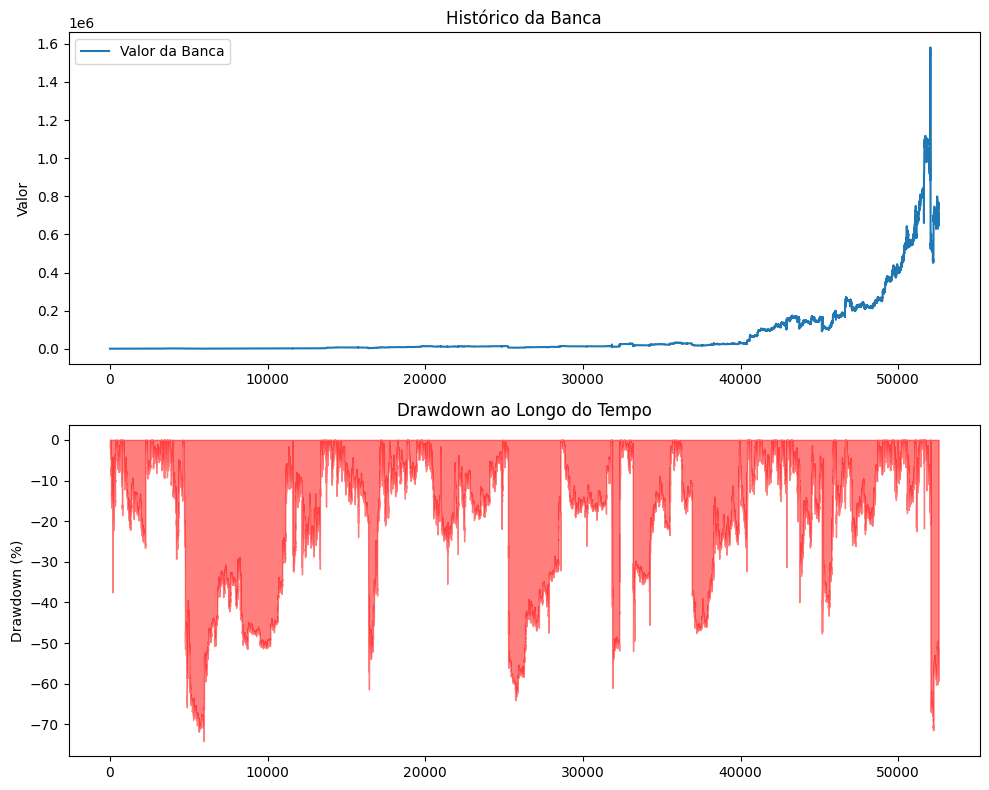

Maior queda: -74.14%
Maior tempo sem lucro: 6898 entradas


In [44]:
def calculate_time_under_water(drawdowns):
    return np.sum(drawdowns < 0)

drawdowns = calculate_drawdowns(history)
max_drawdown = np.min(drawdowns)
time_under_water = calculate_time_under_water(drawdowns)

def calculate_longest_time_under_water(drawdowns):
    """Calcula o maior período 'under water' (tempo em que o valor está abaixo do pico)."""
    in_drawdown = drawdowns < 0
    longest_time = 0
    current_time = 0

    for is_under_water in in_drawdown:
        if is_under_water:
            current_time += 1
            longest_time = max(longest_time, current_time)
        else:
            current_time = 0

    return longest_time

# Calculando o maior tempo under water
longest_time_under_water = calculate_longest_time_under_water(drawdowns)

# Criando gráficos
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Gráfico do histórico da banca
ax1.plot(history, label='Valor da Banca')
ax1.set_title('Histórico da Banca')
ax1.set_ylabel('Valor')
ax1.legend()

# Gráfico do Drawdown
ax2.fill_between(range(len(history)), drawdowns, color='red', alpha=0.5)
ax2.set_title('Drawdown ao Longo do Tempo')
ax2.set_ylabel('Drawdown (%)')

plt.tight_layout()
plt.show()

print('Maior queda: {:.2f}%'.format(max_drawdown))
print('Maior tempo sem lucro: {} entradas'.format(longest_time_under_water))

In [48]:
def get_values_range(df, column, Q1, Q2, Q3):
  IQR = Q3 - Q1

  lower_limit = Q1 - 1.5 * IQR
  upper_limit = Q3 + 1.5 * IQR

  profits = []

  for x in range(0, 100, 25):
    profits.append({
      'range': '{} - {}'.format(x, x + 25),
      'profit': 0,
      'entradas': 0
    })

  ranges = [lower_limit, Q1, Q2, Q3, upper_limit]

  print(ranges)
  
  for index in range(len(ranges) - 1):
    df_aux = df[(df[column] >= ranges[index]) & (df[column] <= ranges[index + 1])]

    profits[index]['profit'] = df_aux['Expected Return'].sum()
    profits[index]['entradas'] = len(df_aux)

  return profits

[-197.0474999999999, 1640.9850000000001, 1957.98, 2866.34, 4704.3725]
[-172.7350000000008, 1638.5149999999999, 1956.99, 2846.0150000000003, 4657.265000000001]


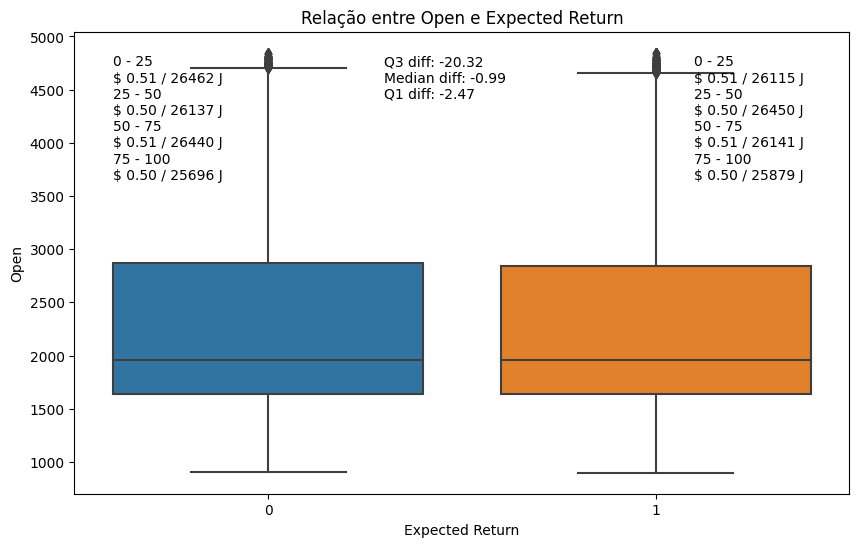

[-204.16249999999968, 1643.98, 1963.48, 2876.075, 4724.2175]
[-180.49, 1641.47, 1962.64, 2856.11, 4678.07]


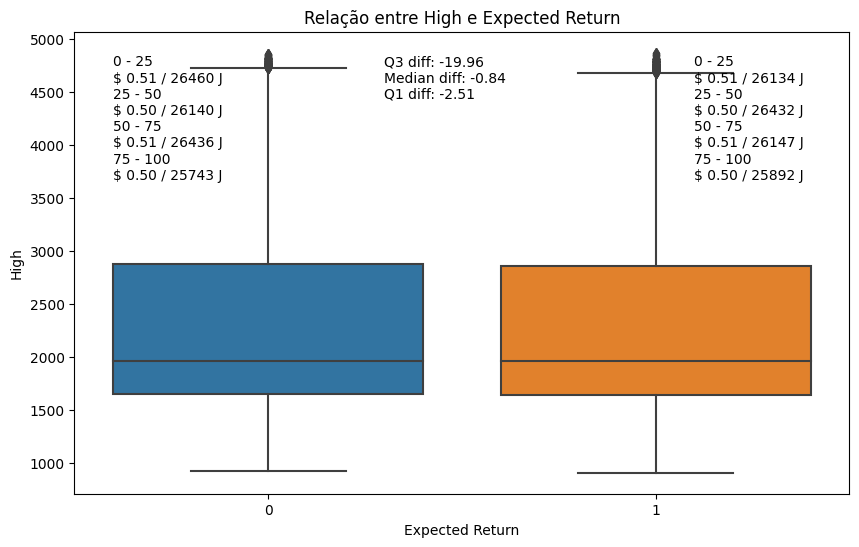

[-187.9575000000002, 1638.33, 1952.88, 2855.855, 4682.1425]
[-165.96249999999986, 1635.89, 1951.44, 2837.125, 4638.9775]


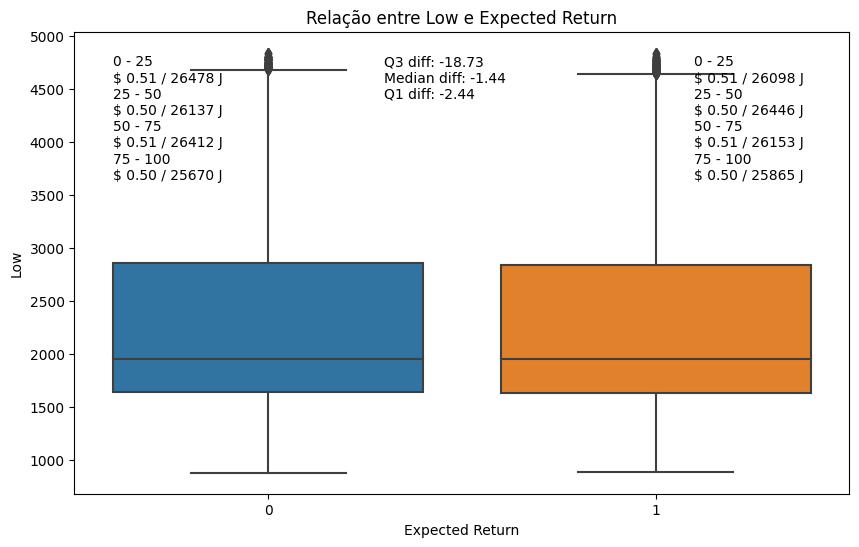

[-197.05499999999984, 1641.0, 1957.68, 2866.37, 4704.424999999999]
[-172.9074999999998, 1638.455, 1956.78, 2846.0299999999997, 4657.3925]


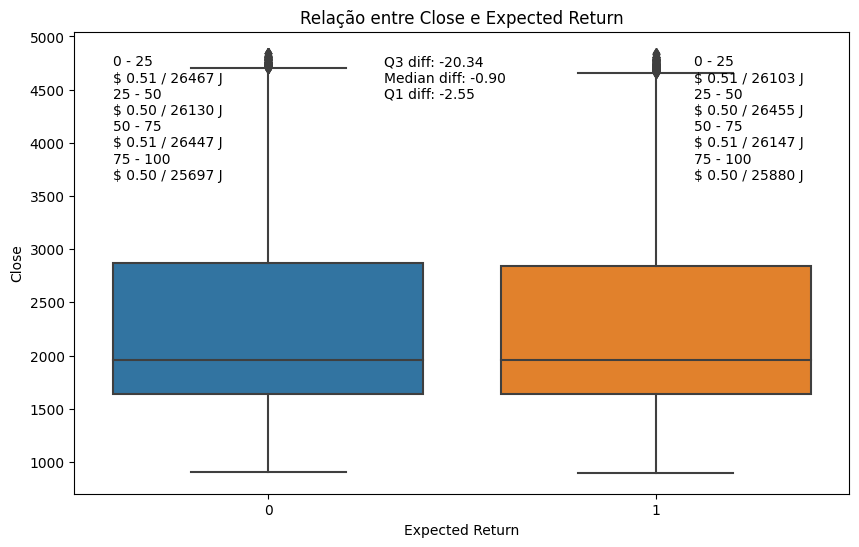

[-5217.200625, 2154.2400900000002, 3797.356, 7068.5339, 14439.974615000001]
[-5279.145175000001, 2172.7562, 3827.9125, 7140.69045, 14592.591825]


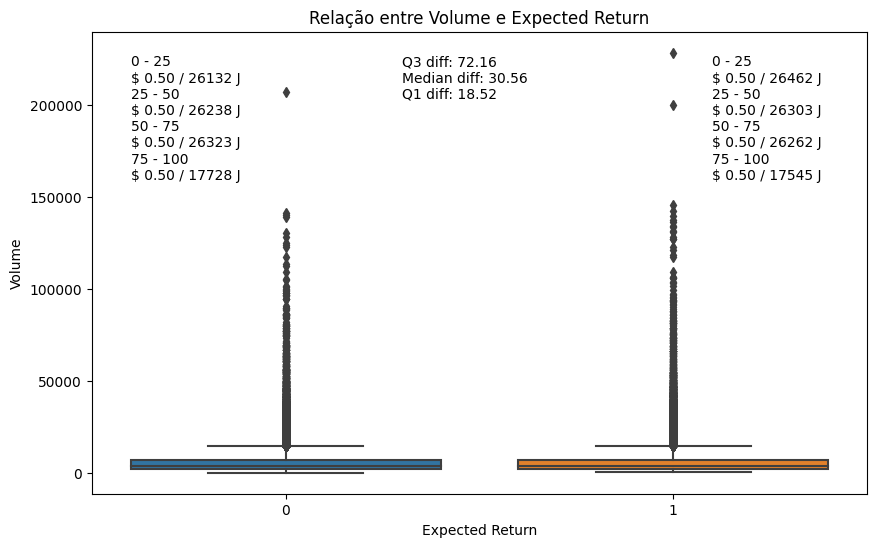

[-13046097.26104157, 4428953.7434435, 8587316.047903, 16078987.746433549, 33554038.75091862]
[-13117022.587626249, 4422354.0965195, 8610136.093795, 16115271.88595, 33654648.57009575]


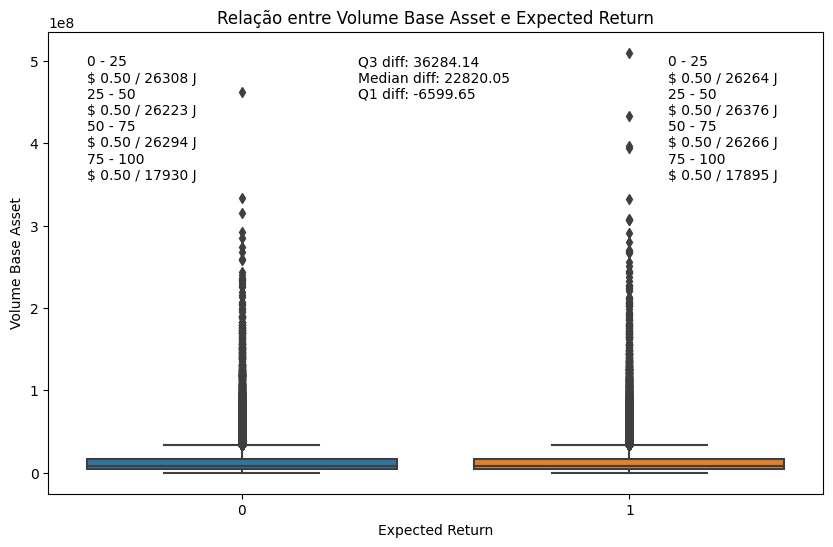

[9.114024141488379, 40.82636091150934, 51.431010051541946, 61.96791875818998, 93.68025552821095]
[6.914220140049647, 38.878741553641376, 49.57748036902428, 60.18842249603586, 92.1529439096276]


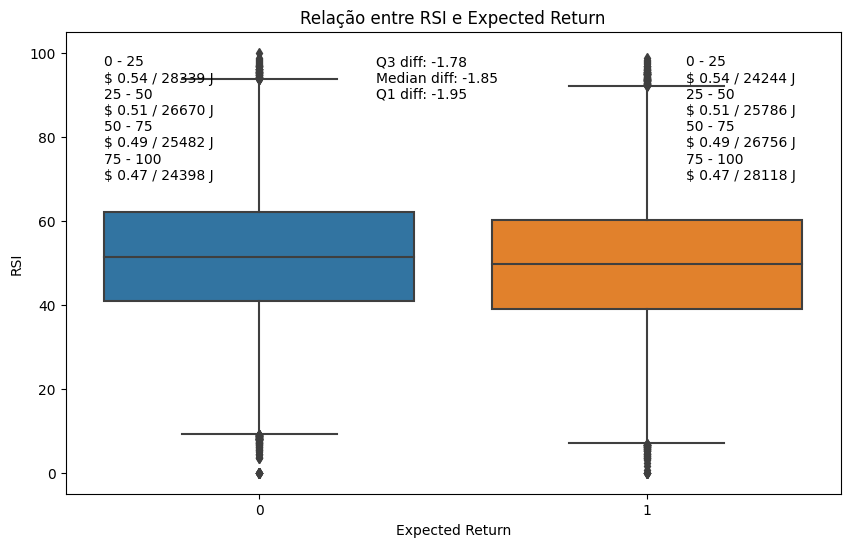

[-228.29218240815385, 1651.472988805834, 1977.6975178949504, 2904.649769615159, 4784.414940829147]
[-202.47264308375702, 1650.1557731792795, 1979.5329489399662, 2885.241384021304, 4737.86980028434]


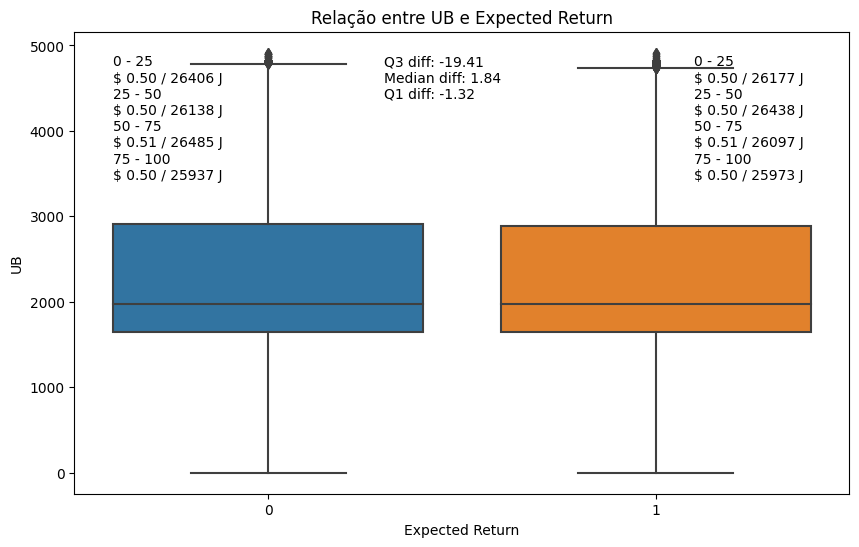

[-168.09025647313388, 1632.1277529079473, 1936.5951024330457, 2832.273092495335, 4632.491101876416]
[-140.23020093544278, 1630.7737161998598, 1936.4301460832758, 2811.4429942900615, 4582.446911425364]


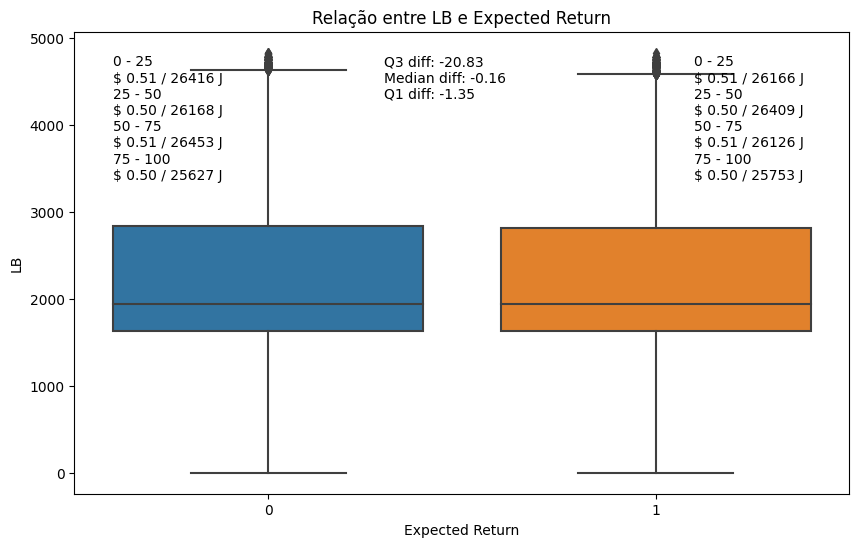

[-14.48032360413697, -3.1642036723342244, 0.262928331218518, 4.379876282200939, 15.695996214003685]
[-14.880184692610783, -3.622802146378376, -0.011678688484153099, 3.882119551109895, 15.139502097342302]


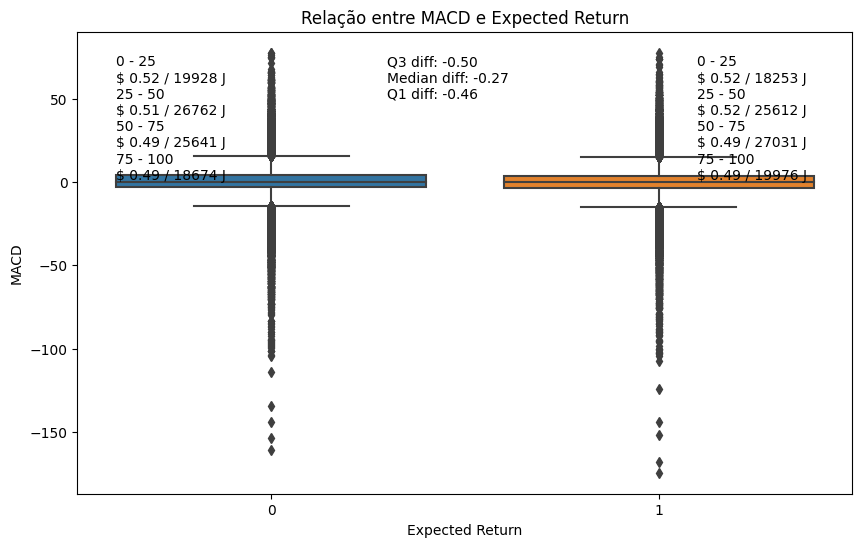

[-14.079308103758386, -3.156944504236056, 0.17477504202293764, 4.12463122877883, 15.046994828301159]
[-14.250016033525878, -3.37372860725431, 0.023521346088803352, 3.877129676926735, 14.753417103198302]


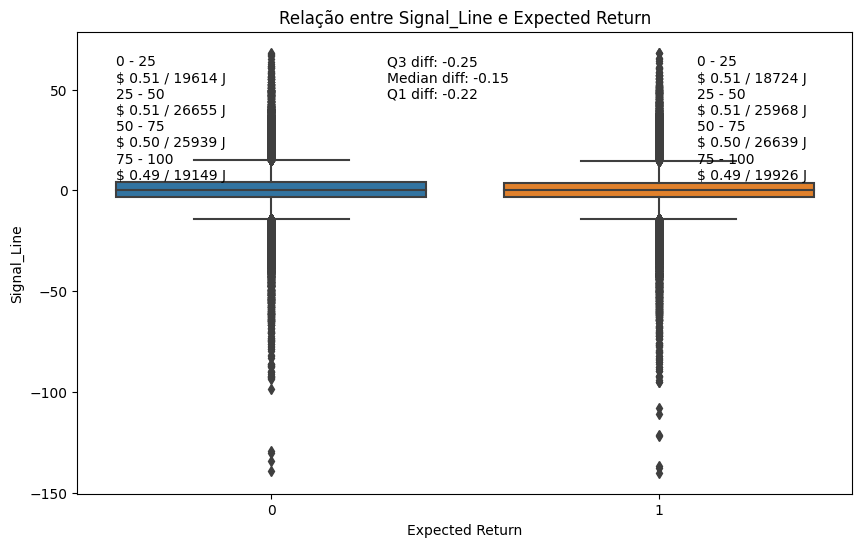

[-13.002321428571411, 5.05071428571428, 9.603571428571351, 17.086071428571408, 35.1391071428571]
[-12.803749999999972, 5.122857142857129, 9.66285714285714, 17.073928571428528, 35.00053571428563]


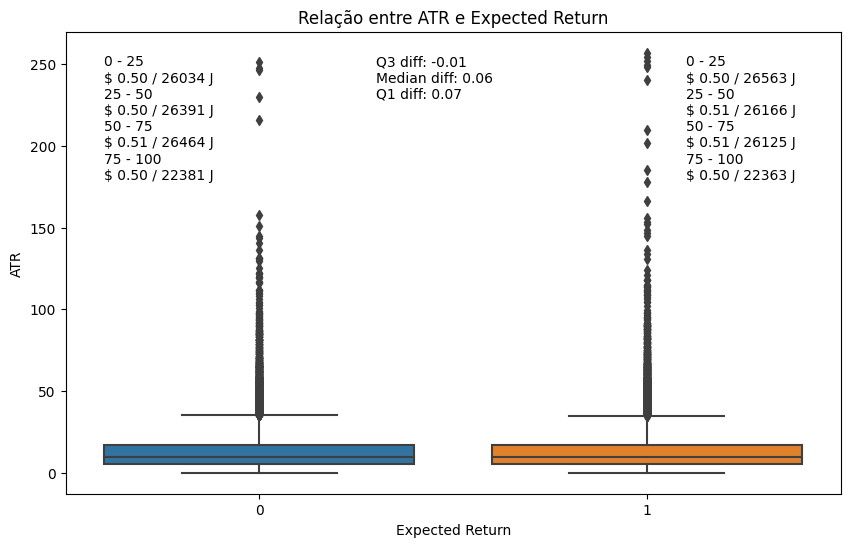

[-22.713234634324536, -4.849572018004683, 0.46974771628299034, 7.059536392875218, 24.923199009195073]
[-22.882720525944315, -4.785809920646267, 0.5815537896377728, 7.27879714955243, 25.375707754850474]


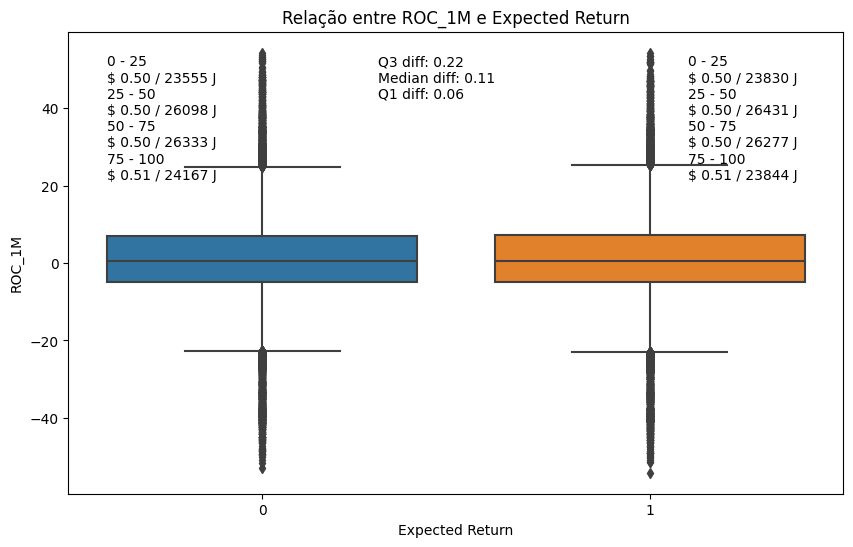

[-9.796089954415752, -2.206887696755782, 0.11791543149334384, 2.8525804750175308, 10.441782732677499]
[-9.93052985251915, -2.2613237887504694, 0.07582482615771675, 2.8514802537619848, 10.520686317530666]


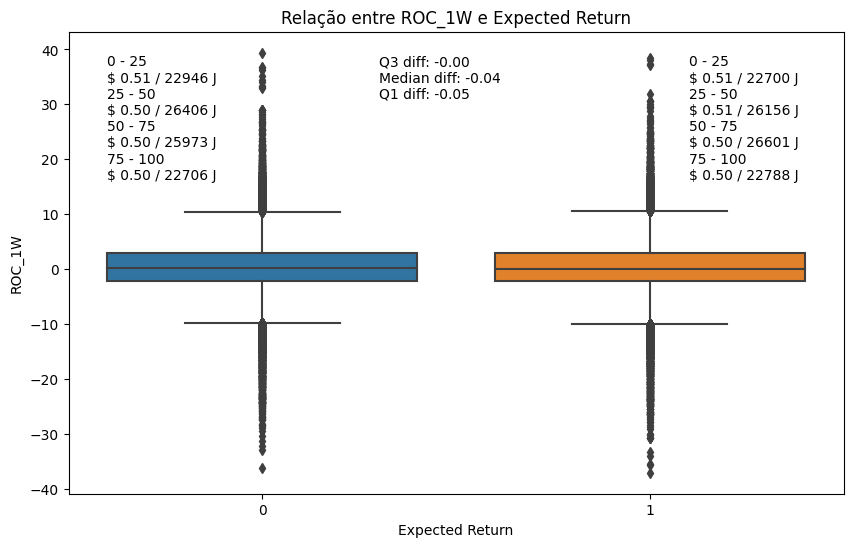

[-134.26410793377636, -67.6599441439727, -44.61538461538405, -23.257168284103585, 43.34699550570008]
[-140.0597067750295, -72.48301815506434, -50.30303030303088, -27.431892408420914, 40.144796211544225]


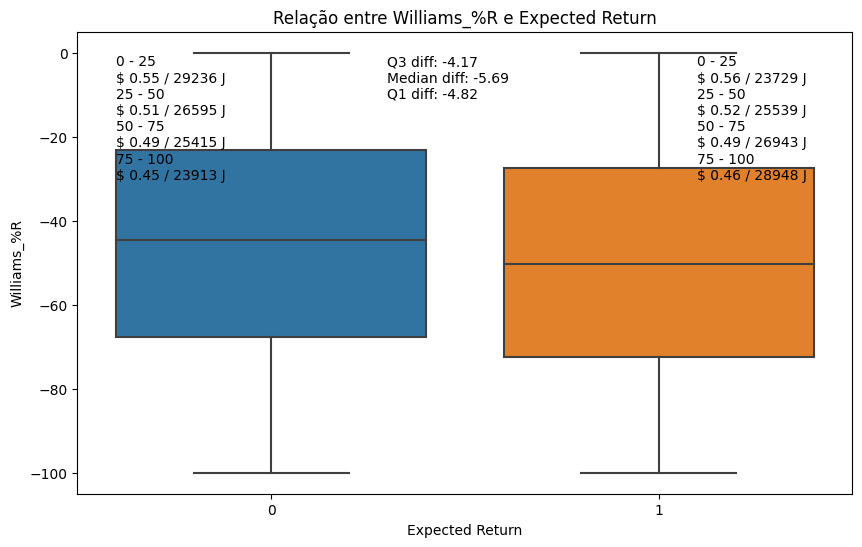

[-34.58849437852123, 32.21967430835784, 55.456026058633455, 76.75845343294388, 143.56662211982297]
[-40.36967970968779, 27.388076920427935, 49.59213319924026, 72.55991467383842, 140.31767130395414]


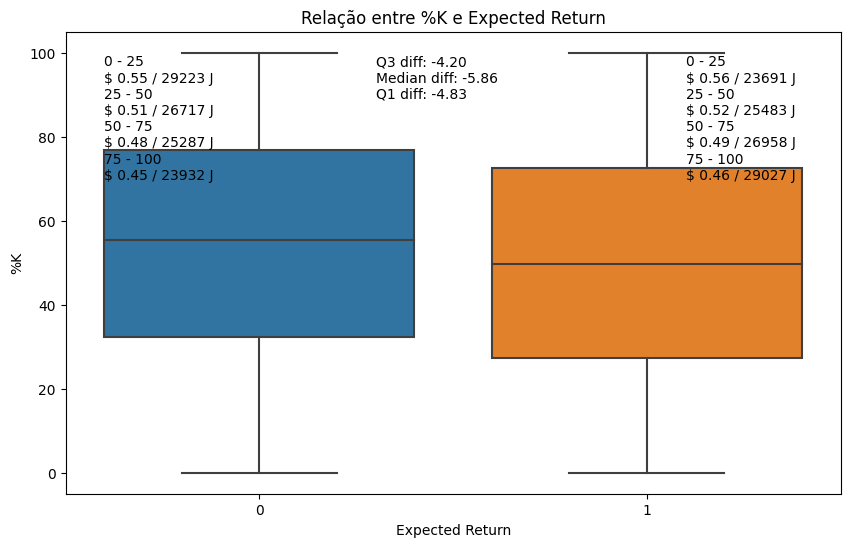

[-30.409029206940303, 32.76988438201295, 54.801155928572236, 74.88916010798178, 138.06807369693502]
[-34.90422168116551, 29.144825375369834, 50.26827632461421, 71.84419007972673, 135.8932371362621]


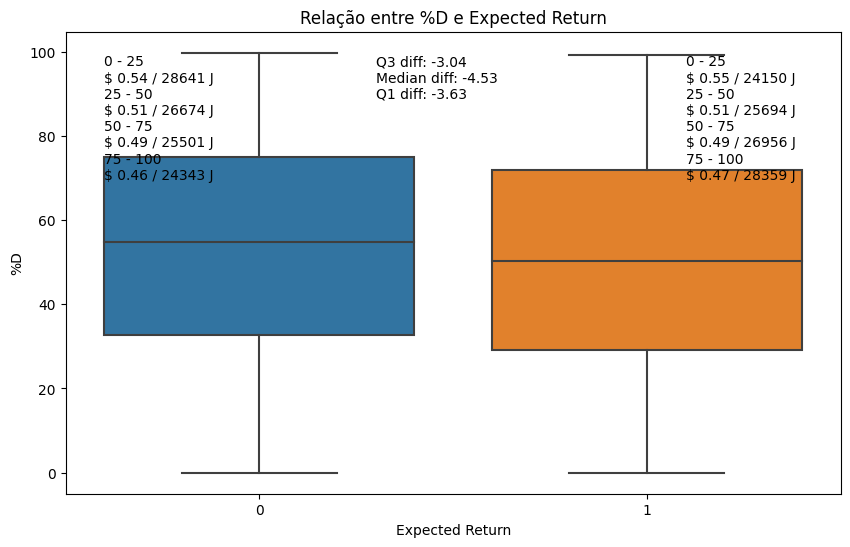

[-1.1237817255414697, 38.008748275690394, 51.11223636189987, 64.09710160984497, 103.22963161107683]
[-2.9323265675724812, 36.25484359644727, 49.1042403658833, 62.379623705793776, 101.56679386981352]


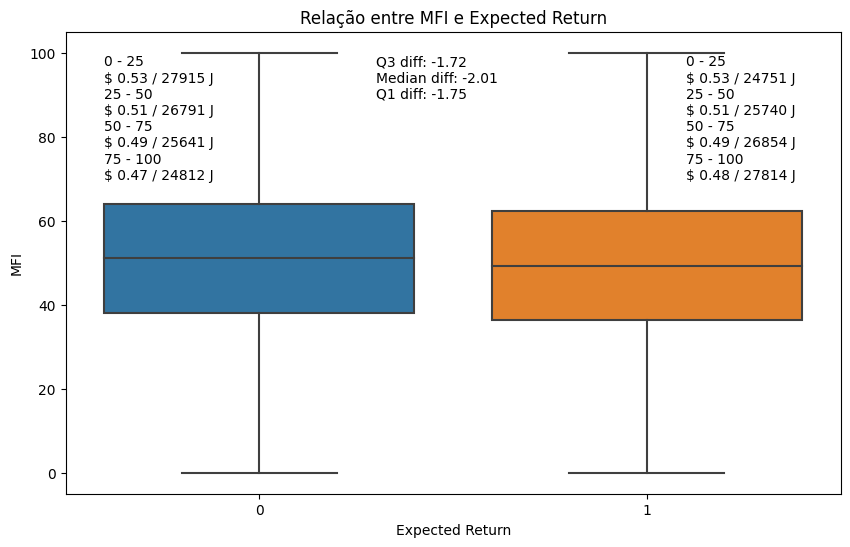

[-0.010961266704891627, -0.002444904366101163, 0.0002887840272151813, 0.003232670526425812, 0.011749032865216277]
[-0.011544267204782967, -0.0029626337344902474, -6.219663812670451e-05, 0.002758455245704899, 0.011340088715997619]


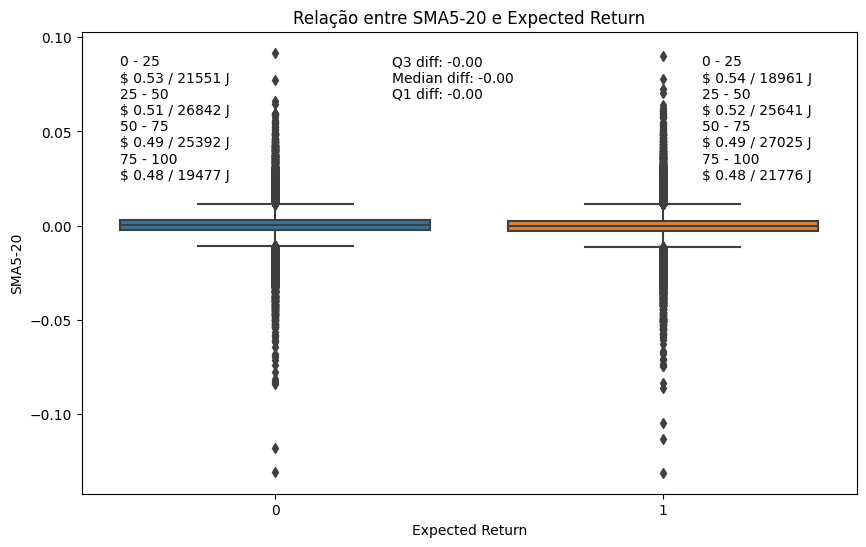

[-0.006040669123728953, -0.0013855005580676073, 0.00013708946805163463, 0.0017179451523732894, 0.006373113718034635]
[-0.006316645007567854, -0.0016113418428305012, -3.2734159707196925e-05, 0.0015255269336610679, 0.006230830098398421]


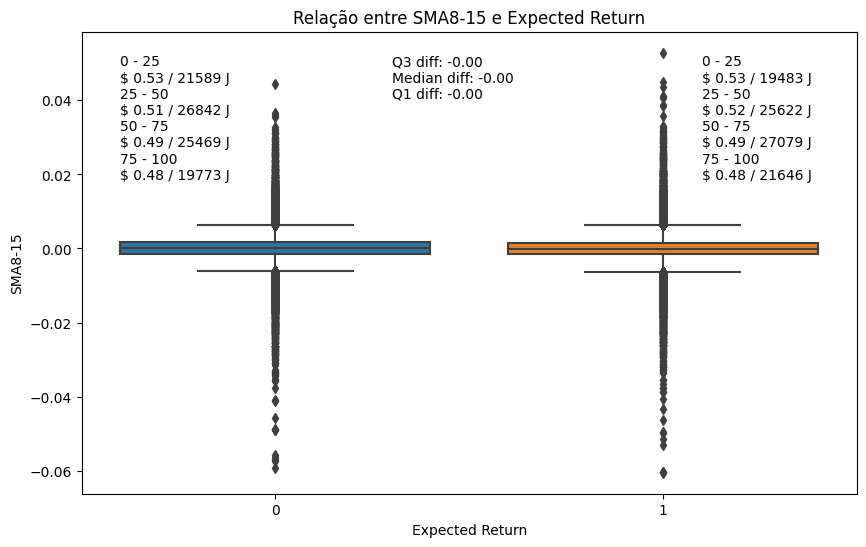

[-0.015222829374663724, -0.003542730544951838, 0.0001610758349189459, 0.00424400200818942, 0.015924100837901307]
[-0.015429853493585319, -0.003719768087930686, 4.6545246121953305e-05, 0.004086955515839069, 0.015797040921493703]


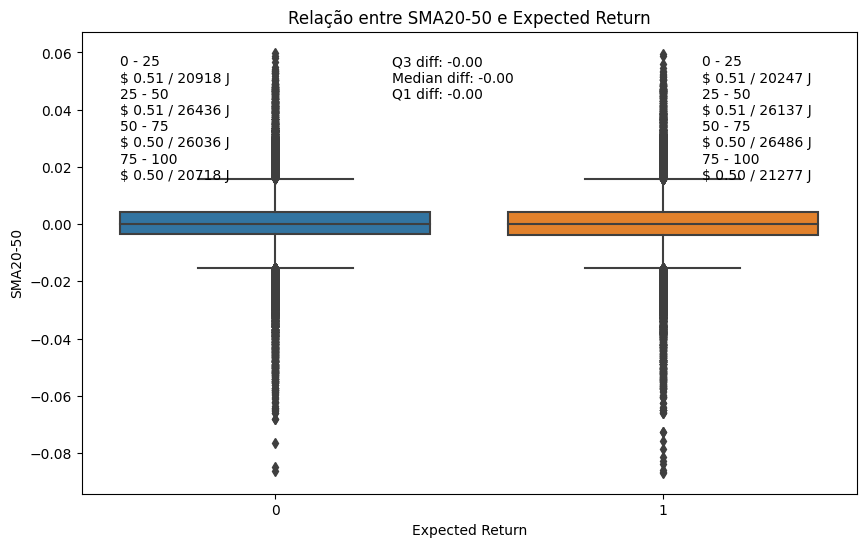

[-0.008530866149900056, -0.0018680318623109345, 0.00026542997782273643, 0.002573857662748479, 0.009236691950337599]
[-0.009039562024565012, -0.0023124135039779524, -6.683918099126012e-05, 0.002172352176413421, 0.008899500697000481]


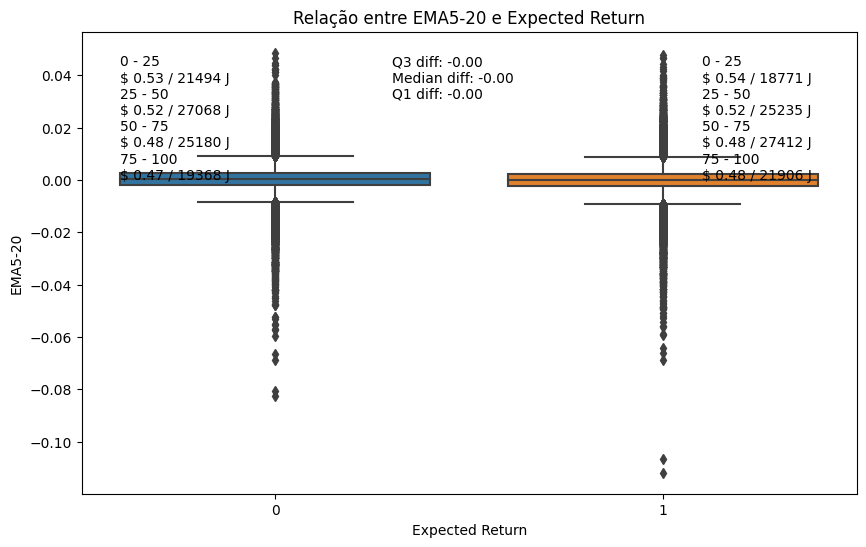

[-0.0041320032269473676, -0.0009083540354287564, 0.0001247499964696877, 0.001240745425583651, 0.004464394617102262]
[-0.004382899722037845, -0.0011214068588280136, -2.8727316100625904e-05, 0.0010529217166452072, 0.004314414579855038]


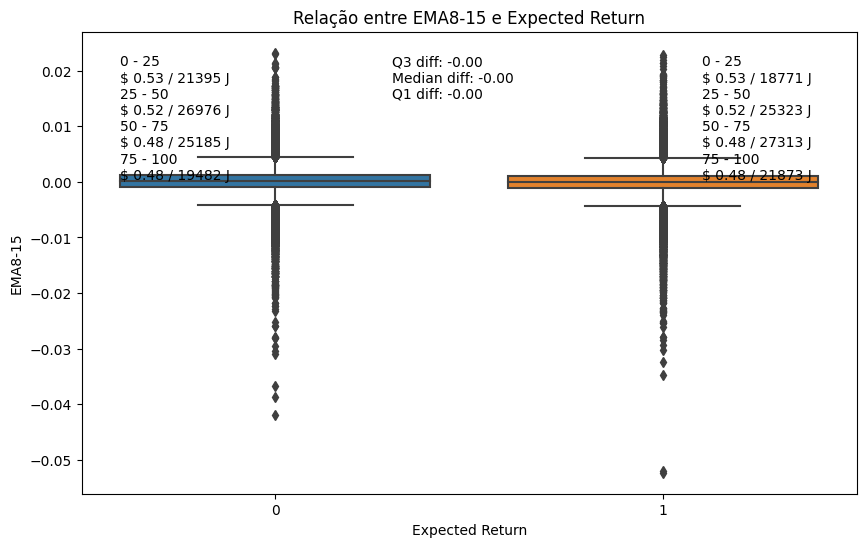

[-0.011893800847118517, -0.0026981846321278286, 0.00017940764693961532, 0.0034322261778659633, 0.012627842392856652]
[-0.012088805288030965, -0.0028802499348520054, 6.874387752934382e-05, 0.0032587869672673015, 0.012467342320446263]


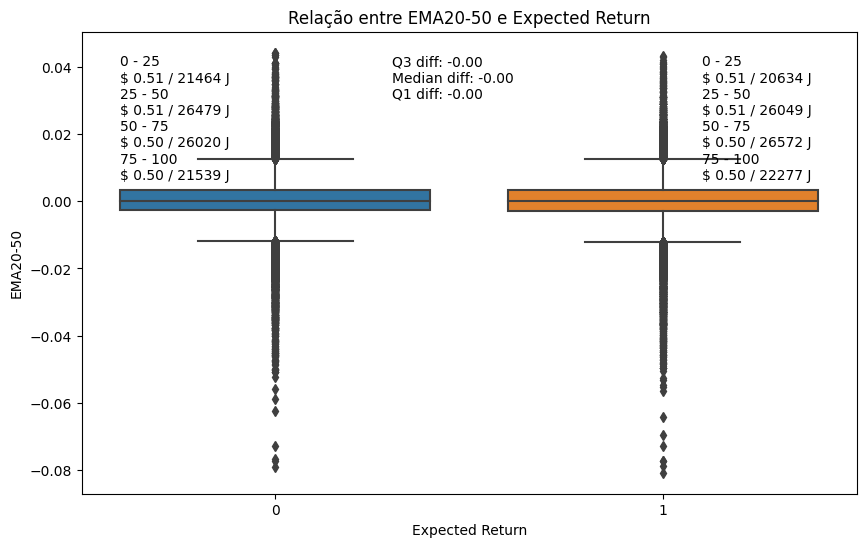

[-134.549950006671, -67.75783384328557, -44.52854671280231, -23.229756401028617, 43.56235976235681]
[-140.3676052367074, -72.60471569043656, -50.402144772118206, -27.429455992922684, 40.333433553348144]


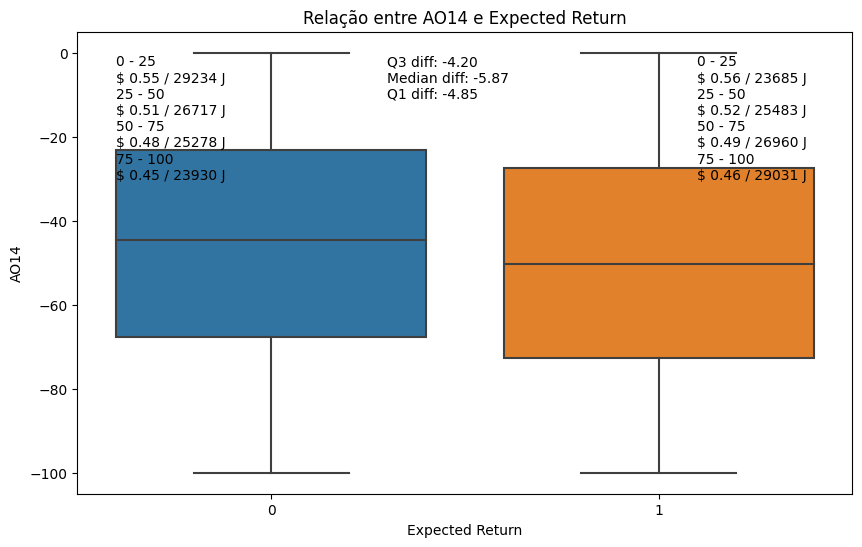

[-8.984473911341109, 3.0022704680977843, 5.601848610041316, 10.993433387723712, 22.980177767162605]
[-8.809352713918175, 3.0139870539042577, 5.6132472635419415, 10.896213565785878, 22.71955333360831]


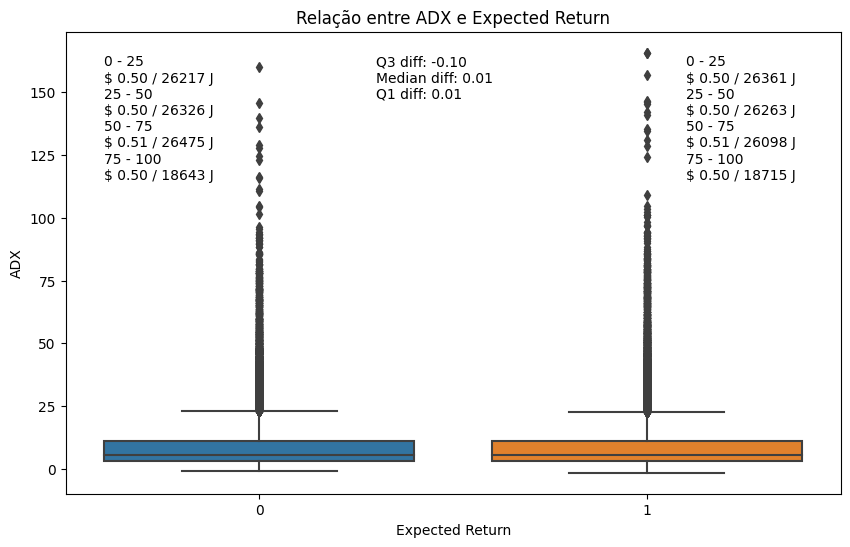

[-0.18166614460742514, 0.06639905382582746, 0.13909485170677283, 0.23177585278132917, 0.47984105121458176]
[-0.18309599909328528, 0.06757642165356138, 0.14015316334522648, 0.23469136881812583, 0.4853637895649725]


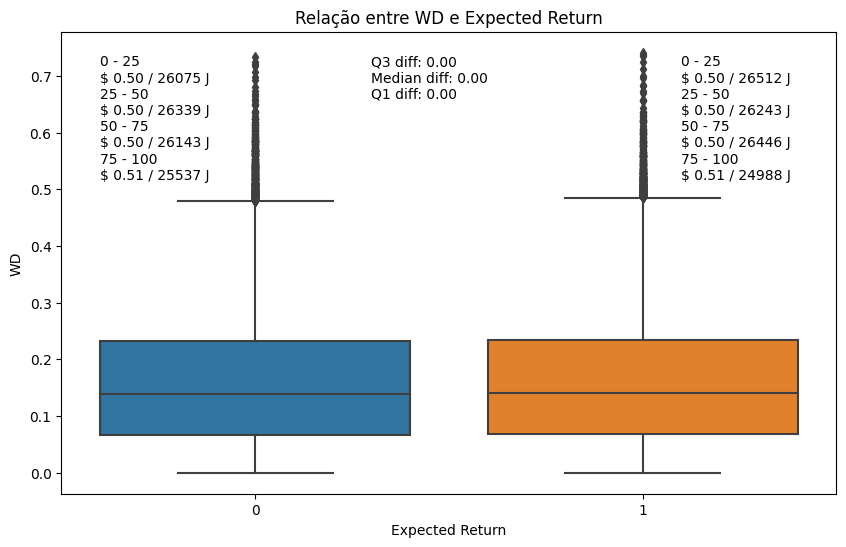

[-0.6843361356921229, -0.15420886658092642, 0.013918187201077578, 0.19920931282653787, 0.7293365819377343]
[-0.7050906404920202, -0.1745764593560477, -0.0006333154494233972, 0.17909966140126726, 0.7096138425372398]


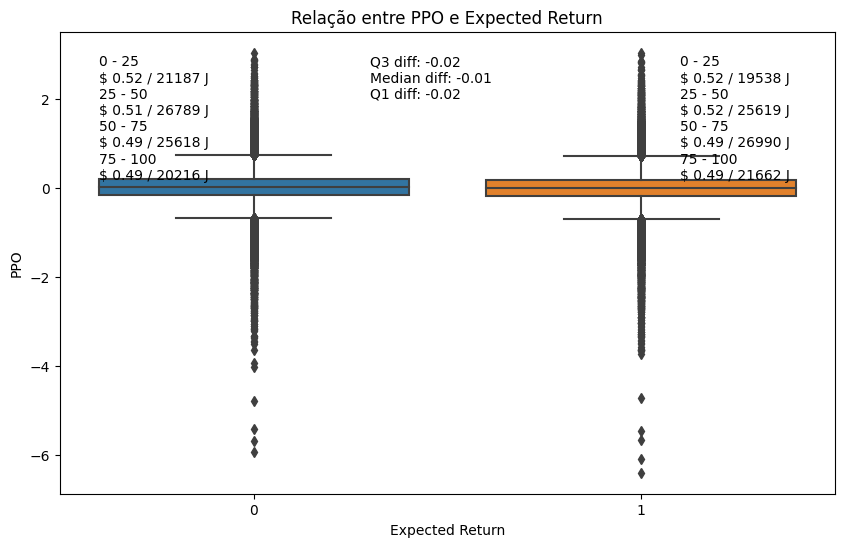

[-48.49291374116058, -11.128762633384397, 1.2674760299065153, 13.780671438466388, 51.144822546242565]
[-50.1711400516603, -12.533913235097248, -0.0603969703741838, 12.557571309278119, 50.194798125841174]


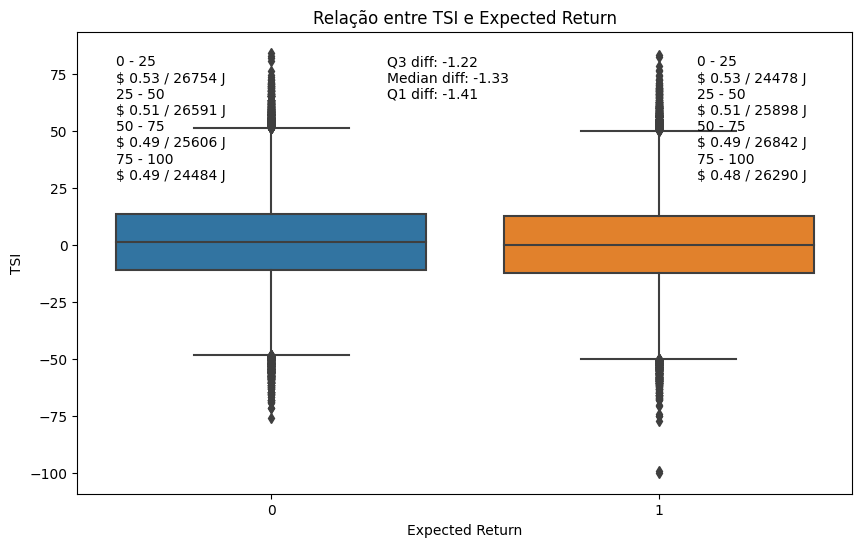

[-84.7251610337594, -19.08524235089687, 2.8027498677950957, 24.67470343767816, 90.3146221205407]
[-88.96147345472936, -23.082988582238983, -1.2483745123537444, 20.8360013327546, 86.71448620524498]


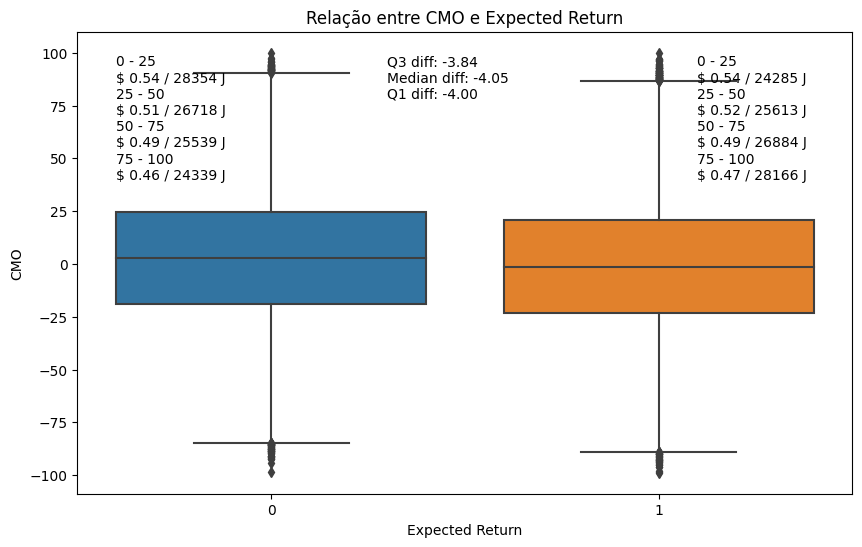

[-43.68514502428329, -13.525107942388825, -4.199482499787553, 6.581583445540816, 36.74162052743527]
[-44.235917470405184, -13.629106629299306, -4.191523735025777, 6.775433931437949, 37.38224477254383]


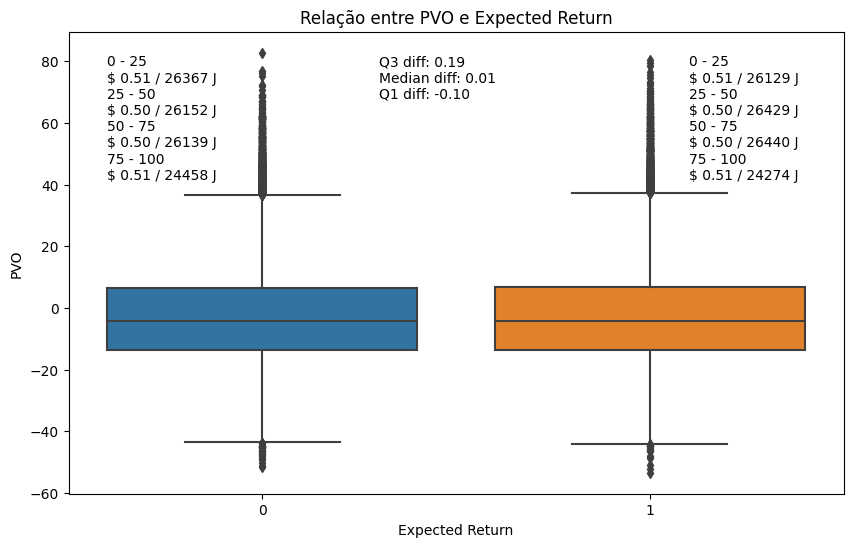

[10509829327.319302, 16500524059.912712, 18789148412.6528, 20494320548.30832, 26485015280.90173]
[10482404148.85686, 16492549392.519962, 18750053236.89833, 20499312888.295364, 26509458131.958466]


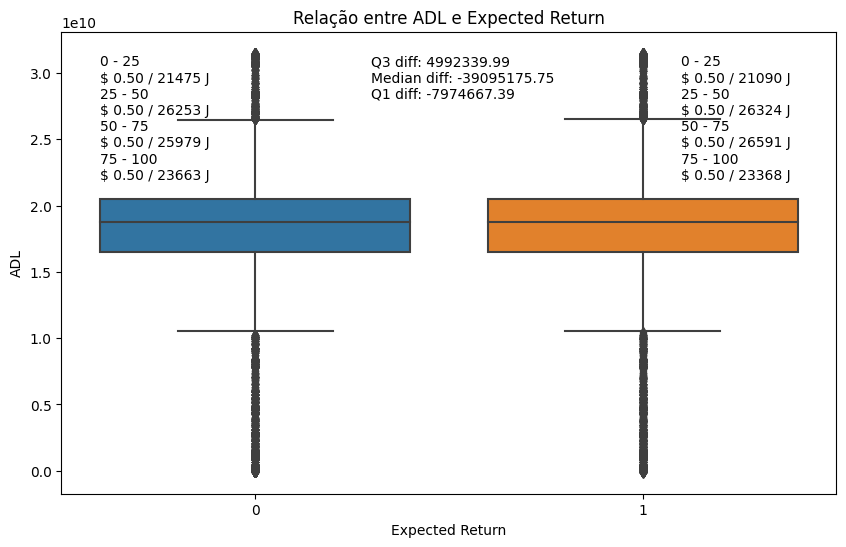

[-79860602623.83884, 81834749491.58853, 146779799361.59885, 189631650901.87344, 351327003017.3008]
[-81947759109.30717, 81282135058.50142, 146921292274.2811, 190102064503.70715, 353331958671.51575]


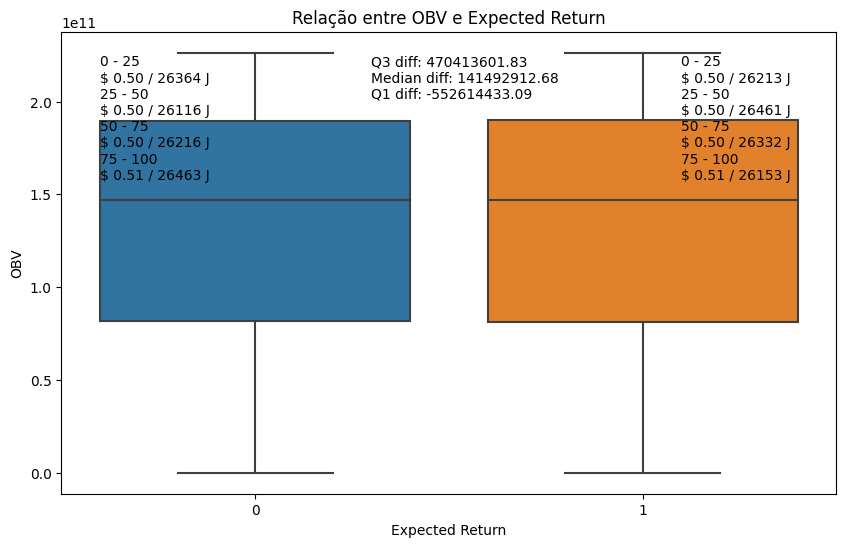

[-354964282.34653515, -71934523.88595872, 3200180.412844921, 116751981.75442556, 399781740.21500194]
[-391380251.62939405, -103759975.20345587, -1308095.0903743878, 87986875.74716958, 375607152.17310774]


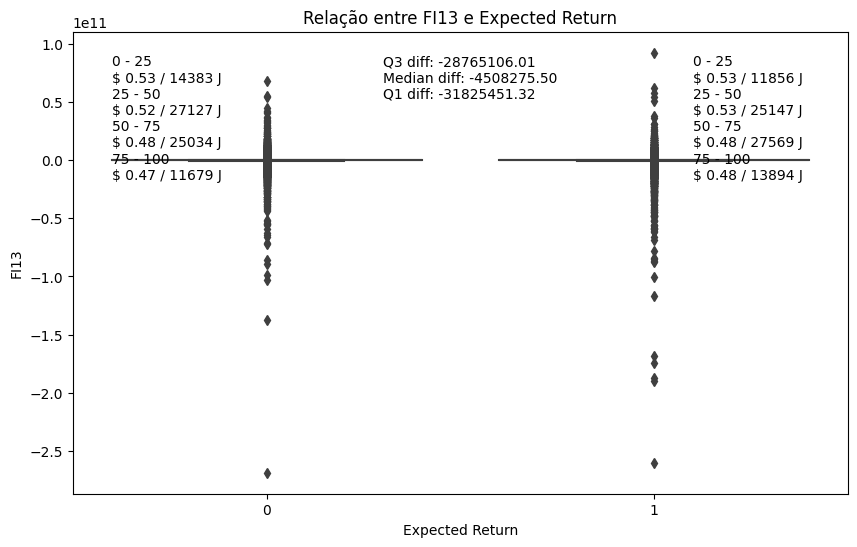

[-816454019.4506516, -169372397.61360645, 2518335.721982071, 262015350.27775702, 909096972.1148022]
[-856182290.5860898, -200546673.1973946, -899383.9234903741, 236543738.39506888, 892179355.7837641]


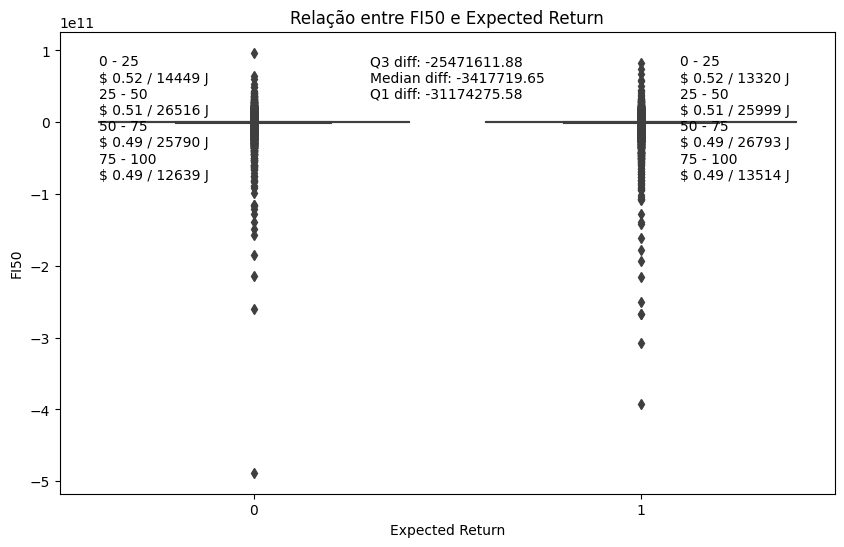

In [49]:
columns_to_plot = [col for col in df.columns if col != 'Expected Return']
# columns_to_plot = [col for col in df.columns if 'Odd Home' in col]

for column in columns_to_plot:
    df_copy = df.copy()

    df_copy['Expected Return'] = df_copy['Expected Return'].apply(lambda x: 1 if x > 0 else 0)

    plt.figure(figsize=(10, 6))
    ax = sns.boxplot(x='Expected Return', y=column, data=df_copy)
    plt.title(f'Relação entre {column} e Expected Return')
    plt.xlabel('Expected Return')
    plt.ylabel(column)

    Q1 = df_copy.groupby('Expected Return')[column].quantile(0.25)
    Q2 = df_copy.groupby('Expected Return')[column].median()
    Q3 = df_copy.groupby('Expected Return')[column].quantile(0.75)

    q1_diff = Q1.diff().iloc[-1]
    median_diff = Q2.diff().iloc[-1]
    q3_diff = Q3.diff().iloc[-1]

    plt.text(0.4, 0.95, f'Q3 diff: {q3_diff:.2f}\nMedian diff: {median_diff:.2f}\nQ1 diff: {q1_diff:.2f}', transform=ax.transAxes, verticalalignment='top')    

    percentis = [
        { # Under 2.5 False
            'Q1': Q1.values[0],
            'Q2': Q2.values[0],
            'Q3': Q3.values[0]
        },
        { # Under 2.5 True
            'Q1': Q1.values[1],
            'Q2': Q2.values[1],
            'Q3': Q3.values[1]
        }
    ]

    for index in range(len((percentis))):
        result = get_values_range(df_copy, column, percentis[index]['Q1'], percentis[index]['Q2'], percentis[index]['Q3'])

        text = ''

        for r in result:
            text += '{}\n$ {:.2f} / {} J\n'.format(r['range'], r['profit'] / r['entradas'], r['entradas'])

        plt.text(0.05 * (1 if index == 0 else 16), 0.95, text, transform=ax.transAxes, verticalalignment='top')
    
    plt.show()